In [1]:
import pandas as pd
import numpy as np 
import re

from sklearn.metrics import precision_recall_curve, mutual_info_score, normalized_mutual_info_score

from pyspark.ml.feature import HashingTF, Tokenizer, IDF, StopWordsRemover, CountVectorizer, VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.functions import explode, lit, col, when

import matplotlib.pyplot as plt

from hashtag_dict import topic_dict

from Evaluation import *
from FeatureExtraction import *
from Filter import *
from TestFramework import *
from LPFormulations import *
from CoverageCalculator import *

In [2]:
%load_ext autoreload
%autoreload 2

# Review Previous Work

In [3]:
class API:
    def __init__(self, directory, frac=1, seed=123):
        if frac < 1:
            self.data = spark.read.parquet(directory).sample(False, frac, seed)
        else:
            self.data = spark.read.parquet(directory)
          
    def get_raw_data(self):
         return self.data

    def get_filtered_data(self, terms=[], hashtags=None, users=None, locs=None, mentions=None):   
        return filter_data(self.data, terms, hashtags, users, locs, mentions)
    
    
class DataPreprocessor():
    def __init__(self, data, topic, load_labled=False, filter_empty_hashtags=False):
        if filter_empty_hashtags == True:
            self.data = data.filter(col("hashtag") != "empty_hashtag")
        else:
            self.data = data

        if load_labled == True:
            labled_dir = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/" + topic
            pos_dir = labled_dir + "/pos"
            topical_tweet_ids = spark.read.parquet(pos_dir)
            topical_tweets = topical_tweet_ids.join(self.data, "tweet_id").withColumn("label", lit(1))
            
            neg_dir = labled_dir + "/neg"
            non_topical_tweet_ids = spark.read.parquet(neg_dir).sample(False, 0.1, 123)
            non_topical_tweets = non_topical_tweet_ids.join(self.data, "tweet_id").withColumn("label", lit(0))

            self.labled_data = topical_tweets.union(non_topical_tweets)
        else:
            self.labled_data = None

        tokenizer = Tokenizer(inputCol="hashtag", outputCol="each_hashtag")
        hashtags_df = tokenizer.transform(self.data)

        hashtag = hashtags_df.select("tweet_id","create_time","each_hashtag")
        self.hash_exploded = hashtag.withColumn('each_hashtag', explode('each_hashtag'))
    
    def get_labled_data(self, topic):
        if self.labled_data == None:
            topic_lables = topic_dict[topic]

            topical_ids = self.hash_exploded.select(self.hash_exploded.tweet_id)\
                                                    .where(self.hash_exploded.each_hashtag\
                                                            .isin(topic_lables))\
                                                    .distinct().cache()

            labled_topical = topical_ids.withColumn("topical", lit(1))
            self.labled_data = self.data.join(labled_topical, self.data.tweet_id == labled_topical.tweet_id, "left")\
                                                      .select(self.data.create_time,\
                                                             self.data.from_id,\
                                                             self.data.from_user,\
                                                             self.data.hashtag,\
                                                             self.data.location,\
                                                             self.data.mention,\
                                                             self.data.tweet_id,\
                                                             self.data.term,\
                                                              F.when(labled_topical.topical == 1, 1.0)\
                                                                .otherwise(0.0).alias("label"))
        return self.labled_data
    
    def get_num_of_positvies(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.where(col("label") == 1.0).count()
    
    def get_data_size(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.count()
        
    def temporal_split(self, topic, balance_data=True, seed=0, remove_topic_hashtags=False):
        topic_lables = topic_dict[topic]
        labled_data = self.get_labled_data(topic)
        tweet_labels = labled_data.select("tweet_id", "label")
        
        df_birthday = self.hash_exploded.join(tweet_labels,\
                                 self.hash_exploded.tweet_id == tweet_labels.tweet_id,\
                                 "inner").select(self.hash_exploded.create_time,\
                                                 self.hash_exploded.each_hashtag,\
                                                 self.hash_exploded.tweet_id)
        
        ## Find out the "birthday", or the earliest appearing time of each hashtag. 
        ## (add an extra column of 1 to mark as topical, will be used in a join later)
        ordered_hashtag_set = df_birthday.\
                              groupby("each_hashtag").\
                              agg({"create_time": "min"}).\
                              orderBy('min(create_time)', ascending=True).\
                              withColumnRenamed("min(create_time)", "birthday").\
                              where(df_birthday.each_hashtag.isin(topic_lables)).cache()
                            
        time_span = ordered_hashtag_set.count()

        train_valid_split_time = np.floor(np.multiply(time_span, 0.75)).astype(int)
        valid_test_split_time = np.floor(np.multiply(time_span, 0.85)).astype(int)

        # Converting to Pandas for random row access.
        pd_ordered_hashtag_set = ordered_hashtag_set.toPandas()
        
        # locate the timestamp of the cutoff point. Will be used later to split Dataframe.
        train_valid_time = pd_ordered_hashtag_set.iloc[train_valid_split_time]['birthday']
        valid_test_time = pd_ordered_hashtag_set.iloc[valid_test_split_time]['birthday']
    
        training_set = labled_data.where(col("create_time") <= train_valid_time)
        validation_set = labled_data.where((col("create_time") > train_valid_time) \
                                           & (col("create_time") <= valid_test_time))
        test_set = labled_data.where(col("create_time") > valid_test_time)
        
        if remove_topic_hashtags == True:
            train_hashtags = pd_ordered_hashtag_set[:train_valid_split_time]['each_hashtag'].tolist()
            train_valid_hashtags = pd_ordered_hashtag_set[:valid_test_split_time]['each_hashtag'].tolist()
            
            train_hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in train_hashtags]
            train_hashtags_regex = '|'.join(train_hashtags_filter)
            invalid_validation_ids = (validation_set.filter(validation_set['hashtag'].rlike(train_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()
            validation_set = validation_set.where(~col("tweet_id").isin(invalid_validation_ids))
            
            train_valid_hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in train_valid_hashtags]
            train_valid_hashtags_regex = '|'.join(train_valid_hashtags_filter)
            invalid_test_ids = (test_set.filter(test_set['hashtag'].rlike(train_valid_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()
                
            test_set = test_set.where(~col("tweet_id").isin(invalid_test_ids))
        
        if balance_data == True:
            train_pos_count = training_set.where(col("label") == 1).count()
            train_neg_count = training_set.count() - train_pos_count
            train_pos_neg_ratio = float(train_pos_count) / train_neg_count
            
            training_set = training_set.sampleBy("label", fractions={0.0: train_pos_neg_ratio, 1.0: 1}, seed=seed)
            
            valid_pos_count = validation_set.where(col("label") == 1).count()
            valid_neg_count = validation_set.count() - valid_pos_count
            valid_pos_neg_ratio = float(valid_pos_count) / valid_neg_count
            
            validation_set = validation_set.sampleBy("label", fractions={0.0: valid_pos_neg_ratio, 1.0: 1}, seed=seed)
            
        return training_set, validation_set, test_set

In [4]:
directory = "/mnt/66e695cd-1a0c-4e3b-9a50-55e01b788529/Training_data/Staging_final/"
api = API(directory)
raw_data = api.get_raw_data()

# Load Natural Disaster Splitted Data

In [5]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Natr_Disaster"

train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna().reset_index()

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Test Classifier

In [6]:
tf = TestFramework(train_pd, validation_pd, test_pd)

Initializing Classifier....
Complete!


# Baseline

In [7]:
baseline_filtered_data = tf.get_filtered_test_data([50, 50, 50, 50, 50])

# LP With Negative Coverage

In [8]:
num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
    get_coverage(test_pd, tf.get_pipeline(), negative=True)

In [9]:
selected_features_neg_coverage = max_cover_with_negs_unweighted(feature_positive_coverage, feature_negative_coverage,\
                                                    num_positive, num_negative, k=50)

In [10]:
get_feature_by_index(tf.get_pipeline(), selected_features_neg_coverage, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,affected,Term,36,2
1,aftershocks,Term,14,0
2,areas,Term,35,4
3,damage,Term,42,1
4,earthquake,Term,44,0
5,flood,Term,64,0
6,floods,Term,70,2
7,hurricane,Term,156,1
8,indian,Term,95,1
9,kashmir,Term,108,2


In [11]:
filtered_data_by_neg_coverage = tf.get_filtered_data_by_index(selected_features_neg_coverage)

# Performance Results

### Training and Evaluating Classifiers

In [12]:
ideal_patk, ideal_ratk, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()
baseline_patk, baseline_ratk, avep_baseline, prec_recall_baseline = tf.run_with_filtered_test_data(baseline_filtered_data)
neg_coverage_patk, neg_coverage_ratk, avep_neg_coverage, prec_recall_neg_coverage = \
    tf.run_with_filtered_test_data(filtered_data_by_neg_coverage)

In [13]:
# RECALL, PREC, Avep

results_pd = pd.DataFrame()

# Ideal
pos = len(test_pd[test_pd.label == 1])
tot = len(test_pd)
print("Number of Topical Tweets = {0}".format(pos))
print("Number of Tweets = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

# Baseline
pos_ret = len(baseline_filtered_data[baseline_filtered_data.label == 1])
tot_ret = len(baseline_filtered_data)
recall = (float)(pos_ret) / pos

baseline_prec = prec_recall_baseline[0]
baseline_recall = recall * prec_recall_baseline[1]
results_pd = results_pd.append([["Baseline (Top Weighted Features in Classifier)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_baseline]])

# LP W/ Negative Coverage
pos_ret = len(filtered_data_by_neg_coverage[filtered_data_by_neg_coverage.label == 1])
tot_ret = len(filtered_data_by_neg_coverage)
recall = (float)(pos_ret) / pos

neg_coverage_prec = prec_recall_neg_coverage[0]
neg_coverage_recall = recall * prec_recall_neg_coverage[1]
results_pd = results_pd.append([["LP with Negative Covereage", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_neg_coverage]])

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "Classifier AveP"]
results_pd

#, , , ,
#total_positives = len(test_pd[test_pd.label == 1])
#total_count = len(test_pd)

Number of Topical Tweets = 3290
Number of Tweets = 1183224


,Model,Topical Retrieved,Total Retrieved,Recall,Precision,Classifier AveP
0,Ideal,3290,1183224,1.000000,0.002781,0.683623
0,Baseline (Top Weighted Features in Classifier),2301,28792,0.699392,0.079918,0.942199
0,LP with Negative Covereage,2642,10216,0.803040,0.258614,0.890860


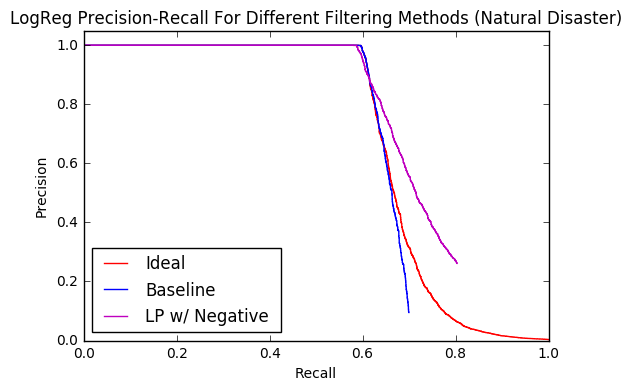

In [14]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')

plt.plot(ideal_prec_recall[1], ideal_prec_recall[0], color=colors[0], label="Ideal")
plt.plot(baseline_recall, baseline_prec, color=colors[1], label="Baseline")
plt.plot(neg_coverage_recall, neg_coverage_prec, color=colors[4], label="LP w/ Negative ")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall For Different Filtering Methods (Natural Disaster)')
plt.show()

# Effect of removing duplicate tweets on the performance

Duplicate tweets present in the data (retweets, ...) pose a challenge in reporting performance evaluations. Here, we use pandas functions to drop rows containing the same terms to have only one copy of each tweet in the data. Another question is that should we remove duplicates from all the data or only test data? To find the answer, We can train and evaluate classifiers in each setting to get a better understanding of the effect of duplicates on the results.

## 1) Drop Duplicates Only in Test Data

In [7]:
test_pd_no_duplicates = test_pd.drop_duplicates(subset='term').reset_index()

In [37]:
len(test_pd)

1182633

In [9]:
len(test_pd_no_duplicates)

1028401

154232 tweets (~13% of the test data) were duplicates and removed.

In [9]:
tf_test_no_duplicate = TestFramework(train_pd, validation_pd, test_pd_no_duplicates)

Initializing Classifier....
Complete!


In [10]:
num_positive_test_no_duplicate, feature_positive_coverage_test_no_duplicate\
 , num_negative_test_no_duplicate, feature_negative_coverage_test_no_duplicate = \
    get_coverage(test_pd_no_duplicates, tf_test_no_duplicate.get_pipeline(), negative=True)

In [178]:
selected_features_neg_coverage_test_no_duplicate = \
    max_cover_with_negs_unweighted(feature_positive_coverage_test_no_duplicate,\
                                   feature_negative_coverage_test_no_duplicate,\
                                   num_positive_test_no_duplicate, num_negative_test_no_duplicate, k=50)

In [17]:
get_feature_by_index(tf_test_no_duplicate.get_pipeline(), selected_features_neg_coverage_test_no_duplicate\
                     , pos_coverages=feature_positive_coverage_test_no_duplicate, \
                     neg_coverages=feature_negative_coverage_test_no_duplicate)

,Feature,Type,Positive Coverage,Negative Coverage
0,affected,Term,35,4
1,areas,Term,34,2
2,damage,Term,36,3
3,earthquake,Term,44,0
4,flood,Term,63,1
5,floods,Term,64,2
6,hurricane,Term,106,2
7,indian,Term,88,10
8,kashmir,Term,97,1
9,napa,Term,41,0


In [204]:
filtered_data_by_neg_coverage_no_test_duplicate = \
 tf_test_no_duplicate.get_filtered_data_by_index(selected_features_neg_coverage_test_no_duplicate)

## 2) Drop Duplicates in Test and Validation Data

In [186]:
validation_pd_no_dups = validation_pd.drop_duplicates(subset='term').reset_index()

In [24]:
len(validation_pd)

18914

In [21]:
len(validation_pd_no_dups)

15603

3311 (~17%) duplicates dropped.

In [179]:
tf_valid_no_duplicate = TestFramework(train_pd, validation_pd_no_dups, test_pd_no_duplicates)

Initializing Classifier....
Complete!


In [194]:
num_positive_valid_no_duplicate, feature_positive_coverage_valid_no_duplicate\
 , num_negative_valid_no_duplicate, feature_negative_coverage_valid_no_duplicate = \
    get_coverage(test_pd_no_duplicates, tf_valid_no_duplicate.get_pipeline(), negative=True)

In [195]:
selected_features_neg_coverage_valid_no_duplicate = \
    max_cover_with_negs_unweighted(feature_positive_coverage_valid_no_duplicate,\
                                   feature_negative_coverage_valid_no_duplicate,\
                                   num_positive_valid_no_duplicate, num_negative_valid_no_duplicate, k=50)

In [201]:
filtered_data_by_neg_coverage_no_valid_duplicate = \
 tf_valid_no_duplicate.get_filtered_data_by_index(selected_features_neg_coverage_valid_no_duplicate)

## 3) Drop Duplicates in Test and Validation and Training Data

In [190]:
train_pd_no_dups = train_pd.drop_duplicates(subset='term').reset_index()

In [32]:
len(train_pd)

99621

In [28]:
len(train_pd_no_dups)

81388

18233 (18%) duplicates dropped.

In [191]:
tf_train_no_duplicate = TestFramework(train_pd_no_dups, validation_pd_no_dups, test_pd_no_duplicates)

Initializing Classifier....
Complete!


In [197]:
num_positive_train_no_duplicate, feature_positive_coverage_train_no_duplicate\
 , num_negative_train_no_duplicate, feature_negative_coverage_train_no_duplicate = \
    get_coverage(test_pd_no_duplicates, tf_train_no_duplicate.get_pipeline(), negative=True)

In [198]:
selected_features_neg_coverage_train_no_duplicate = \
    max_cover_with_negs_unweighted(feature_positive_coverage_train_no_duplicate,\
                                   feature_negative_coverage_train_no_duplicate,\
                                   num_positive_train_no_duplicate, num_negative_train_no_duplicate, k=50)

In [202]:
filtered_data_by_neg_coverage_no_train_duplicate = \
 tf_train_no_duplicate.get_filtered_data_by_index(selected_features_neg_coverage_train_no_duplicate)

## Performance Results

In [205]:
ideal_patk_no_test_duplicate, ideal_ratk_no_test_duplicate, \
 ideal_avep_no_test_duplicate, ideal_prec_recall_no_test_duplicate = tf_test_no_duplicate.get_ideal_performance()
    
ideal_patk_no_valid_duplicate, ideal_ratk_no_valid_duplicate, \
 ideal_avep_no_valid_duplicate, ideal_prec_recall_no_valid_duplicate = tf_valid_no_duplicate.get_ideal_performance()

ideal_patk_no_train_duplicate, ideal_ratk_no_train_duplicate, \
 ideal_avep_no_train_duplicate, ideal_prec_recall_no_train_duplicate = tf_train_no_duplicate.get_ideal_performance()
    
neg_coverage_patk_no_test_duplicate, neg_coverage_ratk_no_test_duplicate,\
 avep_neg_coverage_no_test_duplicate, prec_recall_neg_coverage_no_test_duplicate = \
    tf_test_no_duplicate.run_with_filtered_test_data(filtered_data_by_neg_coverage_no_test_duplicate)
    
neg_coverage_patk_no_valid_duplicate, neg_coverage_ratk_no_valid_duplicate,\
 avep_neg_coverage_no_valid_duplicate, prec_recall_neg_coverage_no_valid_duplicate = \
    tf_valid_no_duplicate.run_with_filtered_test_data(filtered_data_by_neg_coverage_no_valid_duplicate)
    
neg_coverage_patk_no_train_duplicate, neg_coverage_ratk_no_train_duplicate,\
 avep_neg_coverage_no_train_duplicate, prec_recall_neg_coverage_no_train_duplicate = \
    tf_train_no_duplicate.run_with_filtered_test_data(filtered_data_by_neg_coverage_no_train_duplicate)    

In [206]:
results_pd = pd.DataFrame()

# Ideal
pos = len(test_pd_no_duplicates[test_pd_no_duplicates.label == 1])
tot = len(test_pd_no_duplicates)
print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
print("Number of Tweets w/o duplicates = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot]])

# LP W/ Negative Coverage
pos_ret = len(filtered_data_by_neg_coverage_no_test_duplicate[filtered_data_by_neg_coverage_no_test_duplicate.label == 1])
tot_ret = len(filtered_data_by_neg_coverage_no_test_duplicate)
recall = (float)(pos_ret) / pos

neg_coverage_prec = prec_recall_neg_coverage_no_test_duplicate[0]
neg_coverage_recall = recall * prec_recall_neg_coverage_no_test_duplicate[1]
results_pd = results_pd.append([["LP with Negative Covereage", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret]])

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision"]
results_pd

Number of Topical Tweets w/o duplicates= 2872
Number of Tweets w/o duplicates = 1028401


,Model,Topical Retrieved,Total Retrieved,Recall,Precision
0,Ideal,2872,1028401,1.000000,0.002793
0,LP with Negative Covereage,2312,10337,0.805014,0.223663


In [207]:
avep_results = pd.DataFrame([['Ideal (Test)', ideal_avep_no_test_duplicate],
                             ['Ideal (Valid + Test)', ideal_avep_no_valid_duplicate],
                             ['Ideal (All Data)', ideal_avep_no_train_duplicate],
                             ['LP Max Cover (Test)', avep_neg_coverage_no_test_duplicate],
                             ['LP Max Cover (Valid + Test)', avep_neg_coverage_no_valid_duplicate],
                             ['LP Max Cover (All Data)', avep_neg_coverage_no_train_duplicate]])
avep_results.columns = ['Model', 'AveP']
avep_results

,Model,AveP
0,Ideal (Test),0.663271
1,Ideal (Valid + Test),0.663300
2,Ideal (All Data),0.661996
3,LP Max Cover (Test),0.881222
4,LP Max Cover (Valid + Test),0.881458
5,LP Max Cover (All Data),0.879340


While there are differences in performance metrics, the differences are not as large as expected for removing duplicates for the data splits.

# 2) Greedy Max Cover Feature Selector

In [209]:
test = test_pd.drop_duplicates(subset='term').reset_index()
valid = validation_pd.drop_duplicates(subset='term').reset_index()
train = train_pd.drop_duplicates(subset='term').reset_index()

tf = TestFramework(train, valid, test)
num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
    get_coverage(test, tf.get_pipeline(), negative=True)

Initializing Classifier....
Complete!


In [3]:
import time
from sklearn.preprocessing import binarize

def greedy_max_cover(data, pipeline, k=20, print_solve_time=False):

    features = data.drop('label', axis=1)
    labels = data['label']
    transformed_data = pipeline.named_steps['features'].transform(features)

    positive_indices = data.index[data.loc[:, 'label'] == 1]
    positive_set = transformed_data[positive_indices]
    num_positive_tweets = positive_set.shape[0]
    num_features = positive_set.shape[1]
    
    ratio = (float)(len(data[data.label == 1])) / len(data[data.label == 0])
    negative_subset_index = data[data.label == 0].sample(frac=ratio, random_state=123).index
    negative_set = transformed_data[negative_subset_index]
    num_negative_tweets = negative_set.shape[0]
    
    positive_bin = binarize(positive_set)
    negative_bin = binarize(negative_set)

    positive_lil = positive_bin.tolil()
    negative_lil = negative_bin.tolil()
    
    if print_solve_time == True:
        start_time = time.time()

    selected_features = []

    for i in range(k):
        max_score = -99999
        selected_feature = -1

        scores = positive_lil.sum(axis=0) - negative_lil.sum(axis=0)
        selected_feature = scores.argmax()

        if selected_feature not in selected_features:
            selected_features.append(selected_feature)
            positive_lil[:, selected_feature] = 0
            negative_lil[:, selected_feature] = 0
        else:
            break
    
    if print_solve_time == True:
        print("Running Time: {0} Seconds".format(time.time() - start_time))
    
    return selected_features

In [223]:
greedy_selected_features = greedy_max_cover(test, tf.get_pipeline(), k=50, print_solve_time=True)

Running Time: 12.5129699707 Seconds


In [250]:
get_feature_by_index(tf.get_pipeline(), greedy_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,rt,Term,25098,1073
1,ferguson,Hashtag,17749,0
2,empty_location,Location,0,0
3,empty_mention,Mention,0,0
4,ericgarner,Hashtag,4793,0
5,blacklivesmatter,Hashtag,4245,0
6,icantbreathe,Hashtag,3500,0
7,police,Term,3452,8
8,amp,Term,2178,123
9,black,Term,1997,19


In [233]:
filtered_greedy = tf.get_filtered_data_by_index(greedy_selected_features)

## Compare results with LP solution

In [232]:
lp_selected_features = max_cover_with_negs_unweighted(feature_positive_coverage,\
                                   feature_negative_coverage,\
                                   num_positive, num_negative, k=50, time_limit_secs=600, print_elapsed=True)

Running Time: 385.146967888 Seconds


In [234]:
filtered_lp = tf.get_filtered_data_by_index(lp_selected_features)

### Analyze Selected Features in each method:

Features in both results:

In [235]:
common_features = [f for f in greedy_selected_features if f in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), common_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,earthquake,Hashtag,257,0
1,hurricane,Hashtag,140,0
2,storm,Hashtag,123,0
3,typhoon,Hashtag,121,0
4,hurricane,Term,106,2
5,sandy,Hashtag,101,0
6,flood,Hashtag,97,0
7,kashmir,Term,97,1
8,bertha,Hashtag,87,0
9,katrina,Hashtag,85,0


Features only in Greedy solution:

In [236]:
g_features = [f for f in greedy_selected_features if f not in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), g_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,typhoon,Term,98,2
1,california,Term,94,8
2,storm,Term,89,3
3,army,Term,76,5
4,sismo,Hashtag,46,0
5,weatherchannel,Mention,44,0
6,tropical,Term,44,1
7,warning,Hashtag,40,0
8,warning,Term,46,8
9,loc_africa,Location,40,3


Features only in LP solution:

In [237]:
l_features = [f for f in lp_selected_features if f not in greedy_selected_features]
get_feature_by_index(tf.get_pipeline(), l_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,aftershocks,Term,13,0
1,newport,Term,9,2
2,stranded,Term,27,1
3,arthur,Hashtag,28,0
4,cholera,Hashtag,14,0
5,hurricanekatrina,Hashtag,16,0
6,hurricanesandy,Hashtag,16,0
7,typhoonhaiyan,Hashtag,14,0
8,typhoonjet,Hashtag,10,0
9,loc_delhi,Location,17,2


### Classifier Performance Results for the two methods:

In [239]:
_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()
    
_, _, greedy_avep, greedy_prec_recall = tf.run_config_by_index(greedy_selected_features) 

_, _, lp_avep, lp_prec_recall = tf.run_config_by_index(lp_selected_features)

In [240]:
results_pd = pd.DataFrame()

# Ideal
pos = len(test[test.label == 1])
tot = len(test)
print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
print("Number of Tweets w/o duplicates = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

# LP W/ Negative Coverage
pos_ret = len(filtered_lp[filtered_lp.label == 1])
tot_ret = len(filtered_lp)
recall = (float)(pos_ret) / pos

neg_coverage_prec = lp_prec_recall[0]
neg_coverage_recall = recall * lp_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Covereage (Gurobi Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, lp_avep]])

# Greedy
pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
tot_ret = len(filtered_greedy)
recall = (float)(pos_ret) / pos

greedy_prec = greedy_prec_recall[0]
greedy_recall = recall * greedy_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Covereage (Greedy Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, greedy_avep]])

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
results_pd

Number of Topical Tweets w/o duplicates= 2872
Number of Tweets w/o duplicates = 1028401


,Model,Topical Retrieved,Total Retrieved,Recall,Precision,AveP
0,Ideal,2872,1028401,1.000000,0.002793,0.661996
0,LP with Negative Covereage (Gurobi Solver),2312,10334,0.805014,0.223728,0.879340
0,LP with Negative Covereage (Greedy Solver),2192,11071,0.763231,0.197995,0.870105


The Simple Greedy Solver gives us a pretty close result to the LP solver in 1/30 time. Now let's check if the same results hold for other topics:

# 3) Social Issues

In [241]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Social_issue"

train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna()

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [284]:
test = test_pd.drop_duplicates(subset='term').reset_index()
valid = validation_pd.drop_duplicates(subset='term').reset_index()
train = train_pd.drop_duplicates(subset='term').reset_index()

tf = TestFramework(train, valid, test)
num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
    get_coverage(test, tf.get_pipeline(), negative=True)

Initializing Classifier....
Complete!
#pos/#neg = 0.141147128111


In [264]:
greedy_selected_features = greedy_max_cover(test, tf.get_pipeline(), k=50, print_solve_time=True)

Running Time: 49.6717321873 Seconds


In [266]:
get_feature_by_index(tf.get_pipeline(), greedy_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,ferguson,Hashtag,17749,0
1,rt,Term,25098,15026
2,ericgarner,Hashtag,4793,0
3,blacklivesmatter,Hashtag,4245,0
4,icantbreathe,Hashtag,3500,0
5,police,Term,3452,102
6,black,Term,1997,219
7,mikebrown,Hashtag,1651,0
8,protesters,Term,1649,17
9,people,Term,1939,528


In [272]:
filtered_greedy = tf.get_filtered_data_by_index(greedy_selected_features)

In [301]:
num_positive_subset, feature_positive_coverage_subset, num_negative_subset, feature_negative_coverage_subset = \
    get_coverage(test, tf.get_pipeline(), negative=True, positives=3000)

#pos/#neg = 0.141147128111


In [304]:
lp_selected_features = max_cover_with_negs_unweighted(feature_positive_coverage_subset,\
                                   feature_negative_coverage_subset,\
                                   num_positive_subset, num_negative_subset,\
                                   k=50, time_limit_secs=600, print_elapsed=True)

Running Time: 425.059723854 Seconds


In [305]:
get_feature_by_index(tf.get_pipeline(), lp_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,ashamed,Term,32,8
1,berkeley,Term,157,1
2,cameras,Term,140,7
3,cop,Term,878,27
4,cops,Term,1143,18
5,criminal,Term,127,14
6,enforcement,Term,107,5
7,fergus,Term,100,0
8,gun,Term,441,26
9,helicopters,Term,24,1


In [311]:
filtered_lp = tf.get_filtered_data_by_index(lp_selected_features)

### 3-1) Solution Analysis

Features in both solutions:

In [306]:
common_features = [f for f in greedy_selected_features if f in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), common_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,ferguson,Hashtag,17749,0
1,ericgarner,Hashtag,4793,0
2,blacklivesmatter,Hashtag,4245,0
3,icantbreathe,Hashtag,3500,0
4,police,Term,3452,102
5,mikebrown,Hashtag,1651,0
6,protest,Term,1409,41
7,deray,Mention,1179,5
8,cops,Term,1143,18
9,jury,Term,1079,8


Features only in greedy solution:

In [307]:
g_features = [f for f in greedy_selected_features if f not in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), g_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,rt,Term,25098,15026
1,black,Term,1997,219
2,protesters,Term,1649,17
3,people,Term,1939,528
4,grand,Term,1220,40
5,decision,Term,1095,35
6,officer,Term,912,23
7,http,Term,1827,941
8,killed,Term,762,67
9,brown,Term,827,163


Features only in LP solution:

In [308]:
l_features = [f for f in lp_selected_features if f not in greedy_selected_features]
get_feature_by_index(tf.get_pipeline(), l_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,ashamed,Term,32,8
1,berkeley,Term,157,1
2,cameras,Term,140,7
3,criminal,Term,127,14
4,enforcement,Term,107,5
5,fergus,Term,100,0
6,helicopters,Term,24,1
7,homicide,Term,86,1
8,issue,Term,146,33
9,lapse,Term,7,0


### 3-2) Classifier Performance Analysis

In [309]:
_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()
    
_, _, greedy_avep, greedy_prec_recall = tf.run_config_by_index(greedy_selected_features) 

_, _, lp_avep, lp_prec_recall = tf.run_config_by_index(lp_selected_features)

In [313]:
results_pd = pd.DataFrame()

# Ideal
pos = len(test[test.label == 1])
tot = len(test)
print("Number of Topical Tweets w/o duplicates= {0}".format(pos))
print("Number of Tweets w/o duplicates = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

# LP W/ Negative Coverage
pos_ret = len(filtered_lp[filtered_lp.label == 1])
tot_ret = len(filtered_lp)
recall = (float)(pos_ret) / pos

neg_coverage_prec = lp_prec_recall[0]
neg_coverage_recall = recall * lp_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Gurobi Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, lp_avep]])

# Greedy
pos_ret = len(filtered_greedy[filtered_greedy.label == 1])
tot_ret = len(filtered_greedy)
recall = (float)(pos_ret) / pos

greedy_prec = greedy_prec_recall[0]
greedy_recall = recall * greedy_prec_recall[1]
results_pd = results_pd.append([["LP with Negative Coverage (Greedy Solver)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, greedy_avep]])

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "AveP"]
results_pd

Number of Topical Tweets w/o duplicates= 34691
Number of Tweets w/o duplicates = 280470


,Model,Topical Retrieved,Total Retrieved,Recall,Precision,AveP
0,Ideal,34691,280470,1.000000,0.123689,0.913014
0,LP with Negative Coverage (Gurobi Solver),32091,36512,0.925053,0.878917,0.994173
0,LP with Negative Coverage (Greedy Solver),33968,153000,0.979159,0.222013,0.941167


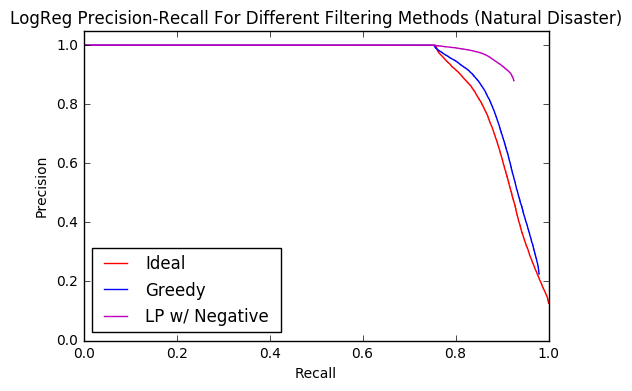

In [317]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')

plt.plot(ideal_prec_recall[1], ideal_prec_recall[0], color=colors[0], label="Ideal")
plt.plot(greedy_recall, greedy_prec, color=colors[1], label="Greedy")
plt.plot(neg_coverage_recall, neg_coverage_prec, color=colors[4], label="LP w/ Negative ")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall For Different Filtering Methods (Natural Disaster)')
plt.show()

# 4) Space

First, process and save data:

In [329]:
output_directory = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/"
topic = "Space"

dp = DataPreprocessor(raw_data, topic)
labled_data = dp.get_labled_data(topic).select("tweet_id", "label")

In [330]:
positives = labled_data.where(col('label') == 1).select("tweet_id")
negatives = labled_data.where(col('label') == 0).select("tweet_id")

In [331]:
pos_dir = output_directory + topic + "/pos" 
positives.write.save(pos_dir, format="parquet")

In [332]:
neg_dir = output_directory + topic + "/neg"
negatives.write.save(neg_dir, format="parquet")

In [333]:
dp = DataPreprocessor(raw_data, topic, load_labled=True, filter_empty_hashtags=True)

In [334]:
train, valid, test = dp.temporal_split(topic, remove_topic_hashtags=True)

In [338]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Space"

#train_pd = train.toPandas()
train_pd.to_csv(temporal_split_directory + topic + "/training.csv", encoding='utf-8', index=False)

In [339]:
valid_pd = valid.toPandas()
valid_pd.to_csv(temporal_split_directory + topic + "/validation.csv", encoding='utf-8', index=False)

In [340]:
test_pd = test.sample(False, 0.3, 123).toPandas()
test_pd.to_csv(temporal_split_directory + topic + "/test.csv", encoding='utf-8', index=False)

(LOAD CSV)

In [4]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Space"

train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna()

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
test = test_pd.drop_duplicates(subset='term').reset_index()
valid = validation_pd.drop_duplicates(subset='term').reset_index()
train = train_pd.drop_duplicates(subset='term').reset_index()

tf = TestFramework(train, valid, test)
#num_positive, feature_positive_coverage, num_negative, feature_negative_coverage = \
#    get_coverage(test, tf.get_pipeline(), negative=True)

Initializing Classifier....
Complete!


In [6]:
greedy_selected_features = greedy_max_cover(test, tf.get_pipeline(), k=10, print_solve_time=True)

Running Time: 4.91759705544 Seconds


In [7]:
get_feature_by_index(tf.get_pipeline(), greedy_selected_features)#, pos_coverages=feature_positive_coverage, \
                     # neg_coverages=feature_negative_coverage)

,Feature,Type
0,houston,Hashtag
1,starwars,Hashtag
2,science,Hashtag
3,sxsw,Hashtag
4,rt,Term
5,iss,Hashtag
6,stem,Hashtag
7,scifi,Hashtag
8,nasa,Mention
9,rockets,Hashtag


In [ ]:
t = tf.get_filtered_data_by_index(greedy_selected_features)

In [11]:
num_positive_subset, feature_positive_coverage_subset, num_negative_subset, feature_negative_coverage_subset = \
    get_coverage(test, tf.get_pipeline(), negative=True, positives=3000)

#pos/#neg = 0.0169957516925


In [13]:
lp_selected_features = max_cover_with_negs_unweighted(feature_positive_coverage_subset,\
                                   feature_negative_coverage_subset,\
                                   num_positive_subset, num_negative_subset,\
                                   k=50, time_limit_secs=600, print_elapsed=True)

Running Time: 114.702833891 Seconds


In [14]:
get_feature_by_index(tf.get_pipeline(), lp_selected_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,comet,Term,373,3
1,moon,Term,676,30
2,space,Term,1393,46
3,aerospace,Hashtag,173,0
4,aliens,Hashtag,840,0
5,antares,Hashtag,253,0
6,apollo,Hashtag,143,0
7,astrology,Hashtag,349,0
8,astronomy,Hashtag,165,0
9,atlantis,Hashtag,308,0


### 3-1) Solution Analysis

Features in both solutions:

In [15]:
common_features = [f for f in greedy_selected_features if f in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), common_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,houston,Hashtag,5260,0
1,starwars,Hashtag,3642,0
2,science,Hashtag,2945,0
3,sxsw,Hashtag,2898,0
4,iss,Hashtag,2445,0
5,stem,Hashtag,2301,0
6,scifi,Hashtag,1786,0
7,nasa,Mention,1783,5
8,rockets,Hashtag,1459,0
9,nasa,Hashtag,1421,0


Features only in greedy solution:

In [16]:
g_features = [f for f in greedy_selected_features if f not in lp_selected_features]
get_feature_by_index(tf.get_pipeline(), g_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,rt,Term,22151,19563
1,job,Hashtag,1511,226
2,loc_houston_tx,Location,1232,39
3,amp,Term,3451,2302
4,tx,Term,1029,24
5,houston,Term,964,17
6,launch,Term,901,43
7,http,Term,1724,890
8,jobs,Hashtag,987,168
9,star,Term,817,88


Features only in LP solution:

In [17]:
l_features = [f for f in lp_selected_features if f not in greedy_selected_features]
get_feature_by_index(tf.get_pipeline(), l_features, pos_coverages=feature_positive_coverage, \
                      neg_coverages=feature_negative_coverage)

,Feature,Type,Positive Coverage,Negative Coverage
0,aerospace,Hashtag,173,0
1,antares,Hashtag,253,0
2,apollo,Hashtag,143,0
3,astrology,Hashtag,349,0
4,astronomy,Hashtag,165,0
5,atlantis,Hashtag,308,0
6,clubpluto,Hashtag,154,0
7,discovery,Hashtag,178,0
8,fullmoon,Hashtag,257,0
9,iris,Hashtag,97,0


In [ ]:
#_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()
    
_, _, greedy_avep, greedy_prec_recall = tf.run_config_by_index(greedy_selected_features) 

#_, _, lp_avep, lp_prec_recall = tf.run_config_by_index(lp_selected_features)

In [19]:
lp_avep

0.99657086157472408